In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
sorted_dd_list

['DD0138',
 'DD0238',
 'DD0287',
 'DD0293',
 'DD0338',
 'DD0438',
 'DD0538',
 'DD0638',
 'DD0738',
 'DD0838',
 'DD0938',
 'DD1038',
 'DD1138',
 'DD1238',
 'DD1338',
 'DD1438',
 'DD1477',
 'DD1478',
 'DD1479',
 'DD1538',
 'DD1638',
 'DD1738',
 'DD1838',
 'DD1938',
 'DD2038',
 'DD2138',
 'DD2238',
 'DD2288',
 'DD2289',
 'DD2338',
 'DD2427']

In [8]:
redshiftlist = []
cutofflist = []
timelist = []
    
snap = "DD0238" # name of the snapshot output
snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives
field = "density"
axis = "y" 
resolution = 70 #[pixel]
quantitylabel = 'Density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]
markersize = 10
fontsize = 15 
plotlabel_linedot = 'Binned mean density'
plotlabel_segment = 'Fitted density of' + " " + snap

In [9]:
ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
z = ds.get_parameter("CosmologyCurrentRedshift")
current_time = ds.current_time.in_units('Gyr').value
width = 200/(1+z) #[kpc]
max_radius = width/2 #[kpc]

yt : [INFO     ] 2023-07-21 16:00:38,592 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-07-21 16:00:38,593 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 16:00:38,594 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 16:00:38,594 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 16:00:38,595 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 16:00:38,596 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-21 16:00:38,596 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 16:00:38,597 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 16:00:38,597 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 16:00:38,598 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|██████████████| 11675/11675 [00:01<00:00, 10627.84it/s]
yt : [INFO     ] 2023-07-21 16:00:40,079 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


In [10]:
frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

yt : [INFO     ] 2023-07-21 16:00:51,410 Projection completed


In [11]:
OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

yt : [INFO     ] 2023-07-21 16:00:51,420 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


In [12]:
radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)

In [13]:
quantitylist

[0.009672104055942434,
 0.0025386326516337204,
 0.001969470247765311,
 0.0009923714591399744,
 0.0010223051171475745,
 0.0008610824793545186,
 0.0005412216531336023,
 0.00035896115647471647,
 0.00026898759374425867,
 0.0002666886730888641,
 0.0002028952551387291,
 0.0001696047986374102,
 0.00016264908594914326,
 0.0001547541851442036,
 0.00016553023087715924,
 0.00018496754361207568]

In [14]:
#nanmask = [np.where(np.array(quantitylist)!=0)][0]

In [15]:
#nanmask

In [16]:
new_quantity = np.array(quantitylist) #[nanmask]

In [17]:
new_radius = np.array(radiuslist) #[nanmask]

In [18]:
p , e = optimize.curve_fit(piecewise_linear, new_radius, np.log10(new_quantity), p0 = [5,1,1,1])

z = ds.get_parameter("CosmologyCurrentRedshift")

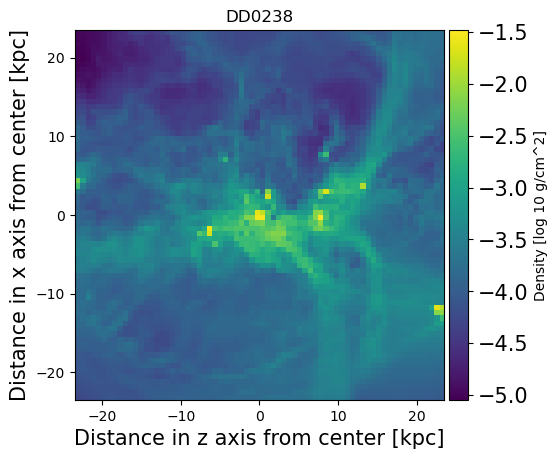

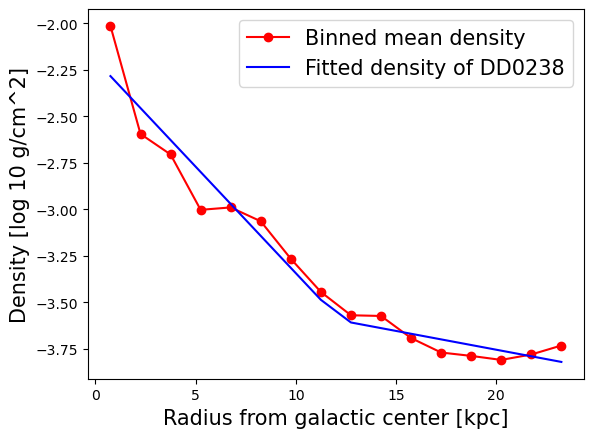

In [19]:
projection_plot = projection(frb, field, width, quantitylabel, axis, snap ,fontsize = 15)
segment_plot = plotting(new_radius, np.log10(new_quantity), piecewise_linear(new_radius, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")


In [20]:
p[0]

12.220505792634649

In [21]:
redpara = ds.get_parameter("CosmologyCurrentRedshift")
redshiftlist.append(redpara)
cutofflist.append(p[0])

In [22]:
ds.get_parameter("CosmologyCurrentRedshift")

3.2538800161868

In [23]:
np.array(frb["gas",field])

array([[9.78512938e-06, 1.06247575e-05, 1.13767542e-05, ...,
        1.80421659e-04, 1.72718117e-04, 1.51918836e-04],
       [9.81387934e-06, 1.00553374e-05, 1.12858917e-05, ...,
        1.73172108e-04, 1.69323709e-04, 1.62034458e-04],
       [9.98500206e-06, 9.96292627e-06, 1.10748153e-05, ...,
        1.71481465e-04, 1.76039141e-04, 1.56432539e-04],
       ...,
       [6.57764716e-05, 6.74244562e-05, 6.90298084e-05, ...,
        1.14461751e-04, 1.11827750e-04, 1.08983195e-04],
       [6.05264346e-05, 6.42860118e-05, 6.66855029e-05, ...,
        1.04293098e-04, 1.01714801e-04, 9.91061002e-05],
       [5.31001774e-05, 5.52254572e-05, 5.95501468e-05, ...,
        9.52882309e-05, 9.27240642e-05, 9.04748849e-05]])

yt : [INFO     ] 2023-07-21 16:01:03,047 Projection completed
yt : [INFO     ] 2023-07-21 16:01:03,049 xlim = 16851.193718 17051.193718
yt : [INFO     ] 2023-07-21 16:01:03,050 ylim = 16653.003939 16853.003939
yt : [INFO     ] 2023-07-21 16:01:03,051 xlim = 0.498197 0.504109
yt : [INFO     ] 2023-07-21 16:01:03,052 ylim = 0.492337 0.498250
yt : [INFO     ] 2023-07-21 16:01:03,054 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



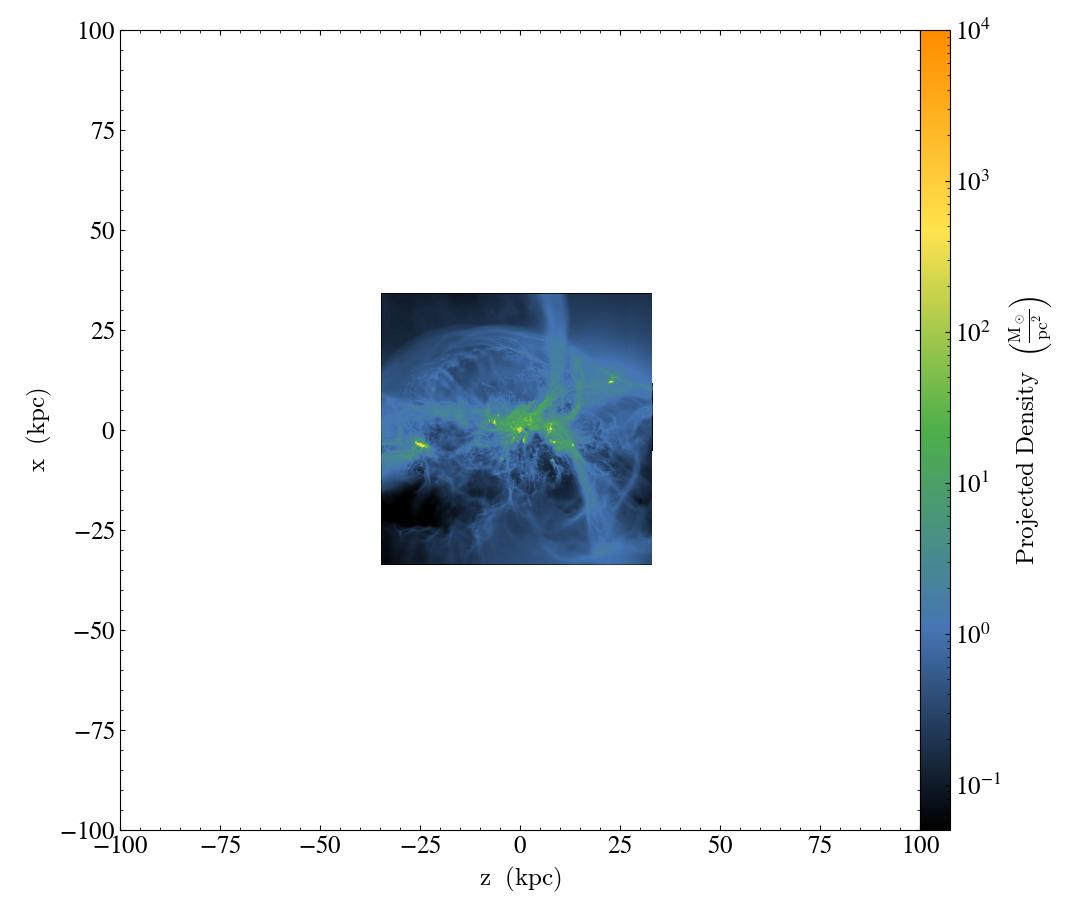

In [24]:
proj = yt.ProjectionPlot(ds, "y", ('gas', 'density'), center=ds.halo_center_kpc, width=(200., 'kpc'), data_source=refine_box)
proj.set_unit('density', 'Msun/pc**2')           # change the units of the density to solar masses per square parsec
proj.set_cmap('density', density_color_map)      # change the color map used
proj.set_zlim('density', density_proj_min, density_proj_max)

In [25]:
ds.current_time.in_units('Gyr').value+0

1.991808986859407

In [26]:
listlist.append(ds.current_time.in_units('Gyr').value)

NameError: name 'listlist' is not defined

In [ ]:
listlist